In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets
import copy
%matplotlib inline

## Loading the dataset

In [2]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

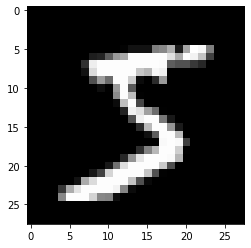

In [3]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

## Training a linear model

In [5]:
linear_regression = tnn.LinearLayer(input_size, output_size, optimizer=tnn.Adam())

accuracy_list = []
for epoch in range(EPOCHS):
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = linear_regression.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = linear_regression.backward(dy)

        linear_regression.update()
        
        if index % 100 == 0:
            
            print('\nTRAIN',index, '-> ', loss)
            yout = linear_regression.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = linear_regression.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))            


TRAIN 0 ->  6.573554979163173
EPOCH =  0 accuracy =  17.119999999999997
10272 / 60000
   TEST   accuracy =  16.56
1656 / 10000

TRAIN 100 ->  5.77619512263575
EPOCH =  0 accuracy =  86.61999999999999
51972 / 60000
   TEST   accuracy =  87.58
8758 / 10000

TRAIN 200 ->  5.780140299422013
EPOCH =  0 accuracy =  87.02333333333333
52214 / 60000
   TEST   accuracy =  87.41
8741 / 10000

TRAIN 300 ->  5.769847555419938
EPOCH =  0 accuracy =  89.79166666666667
53875 / 60000
   TEST   accuracy =  89.7
8970 / 10000

TRAIN 400 ->  5.807826107322364
EPOCH =  0 accuracy =  88.545
53127 / 60000
   TEST   accuracy =  88.55
8855 / 10000

TRAIN 500 ->  5.782950208814701
EPOCH =  0 accuracy =  87.68
52608 / 60000
   TEST   accuracy =  88.28
8828 / 10000

TRAIN 600 ->  5.784876574721459
EPOCH =  0 accuracy =  86.37333333333333
51824 / 60000
   TEST   accuracy =  86.21
8621 / 10000

TRAIN 700 ->  5.814830075769511
EPOCH =  0 accuracy =  87.97500000000001
52785 / 60000
   TEST   accuracy =  88.37
8837 / 

EPOCH =  6 accuracy =  89.54333333333334
53726 / 60000
   TEST   accuracy =  89.0
8900 / 10000

TRAIN 500 ->  5.808451805920621
EPOCH =  6 accuracy =  87.90666666666667
52744 / 60000
   TEST   accuracy =  87.42
8742 / 10000

TRAIN 600 ->  5.760564898676058
EPOCH =  6 accuracy =  88.675
53205 / 60000
   TEST   accuracy =  87.71
8771 / 10000

TRAIN 700 ->  5.816435310643937
EPOCH =  6 accuracy =  90.28
54168 / 60000
   TEST   accuracy =  89.99000000000001
8999 / 10000

TRAIN 800 ->  5.887233482628766
EPOCH =  6 accuracy =  89.24833333333333
53549 / 60000
   TEST   accuracy =  88.67
8867 / 10000

TRAIN 900 ->  5.832788368711256
EPOCH =  6 accuracy =  88.80833333333334
53285 / 60000
   TEST   accuracy =  88.59
8859 / 10000

TRAIN 0 ->  5.770628229293887
EPOCH =  7 accuracy =  85.99833333333333
51599 / 60000
   TEST   accuracy =  85.8
8580 / 10000

TRAIN 100 ->  5.701448132483066
EPOCH =  7 accuracy =  88.74666666666667
53248 / 60000
   TEST   accuracy =  88.71
8871 / 10000

TRAIN 200 ->  5

## Creating a Soft Decision Tree classes

In [5]:
class LeafNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.fc = tnn.LinearLayer(input_dim, output_dim, optimizer=tnn.Adam(learning_rate))
        self.prob = None
        self.del_outputs = None
        self.del_prob = None
        
    def forward(self, inputs):
        fc_out = self.fc.forward(inputs)
        return fc_out
    
    def backward(self, del_outputs):
        self.del_outputs = del_outputs
        del_inputs = self.fc.backward(del_outputs)
        return del_inputs
    
    def update(self):
        self.fc.update()
        

class InnerNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.fc = tnn.NonLinearLayer(input_dim, 1, activation=tnn.Sigmoid(), optimizer=tnn.Adam(learning_rate))
        self.probs = None
        self.left = None
        self.right = None
        
        self.prob_left = None
        self.prob_right = None
        
        self.out_left = None
        self.out_right = None
        return
    
    def create_child(self, depth):
        if depth > 1:
            self.left = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.left.create_child(depth-1)
            self.right.create_child(depth-1)
        else:
            self.left = LeafNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = LeafNode(self.input_dim, self.output_dim, self.learning_rate)

    
    def forward(self, inputs):
        self.probs = self.fc.forward(inputs)
        self.prob_left = self.probs
        self.prob_right = (1-self.probs)        
        
        self.out_left = self.left.forward(inputs)
        self.out_right = self.right.forward(inputs)
        
        output = self.out_left*self.prob_left + self.out_right*self.prob_right
        return output
    
    def backward(self, del_outputs):
        del_out_left = del_outputs*self.prob_left
        del_out_right = del_outputs*self.prob_right

        del_inp_left = self.left.backward(del_out_left)
        del_inp_right = self.right.backward(del_out_right)
        
        del_prob_left = np.mean(self.out_left*del_outputs, axis=1, keepdims=True)
        del_prob_right = np.mean(self.out_right*del_outputs, axis=1, keepdims=True)
        
        del_probs = (del_prob_left - del_prob_right)
        del_inp_probs = self.fc.backward(del_probs)
        
        del_inputs = del_inp_left + del_inp_right + del_inp_probs
        
        return del_inputs
        
        
    def update(self):
        self.fc.update()
        self.left.update()
        self.right.update()
        
    def harden_decision(self, magnitude):
        factor = magnitude/np.linalg.norm(self.fc.weights)
        self.fc.weights = self.fc.weights * factor
        self.fc.bias = self.fc.bias * factor
        
        if type(self.left) == InnerNode:
            self.left.harden_decision(magnitude)
        if type(self.right) == InnerNode:
            self.right.harden_decision(magnitude)
            
    def forward_hard(self, inputs):
        self.probs = self.fc.forward(inputs)
        
        self.prob_left = self.probs>0.5
        self.prob_right = ~self.prob_left        
        
        if type(self.left) == InnerNode:
            self.out_left = self.left.forward_hard(inputs)
            self.out_right = self.right.forward_hard(inputs)
        else:
            self.out_left = self.left.forward(inputs)
            self.out_right = self.right.forward(inputs)
            
        output = self.out_left*self.prob_left + self.out_right*self.prob_right
        return output

### Training Soft Decision Tree

In [74]:
np.random.seed(27)
tree_depth = 3
sdt = InnerNode(input_size, output_size)
sdt.create_child(tree_depth)

In [75]:
learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 20

accuracy_list = []

# magnitude = 0.
for epoch in range(EPOCHS):
    
#     sdt.harden_decision(np.power(10, magnitude/1000.))
#     mag = np.power(10, (epoch+1)/5)
#     sdt.harden_decision(mag)
    
    for index in range(train_size // batch_size):
        epoch_ = epoch/5+index/num_batches
        mag = np.power(10,epoch_)
        sdt.harden_decision(mag)
        
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()
#         magnitude += 1.

        if index % 100 == 0:
            print('\nTRAIN',index, '-> ', loss)

    yout = sdt.forward(train_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(train_label_)).sum()

    accuracy = correct / len(train_label_) * 100.
    print('EPOCH = ',epoch,'accuracy = ', accuracy)
    print(correct, '/', len(train_label_))

    yout = sdt.forward(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy_ = correct / len(test_label_) * 100.
    print('   TEST  ','accuracy = ', accuracy_)
    print(correct, '/', len(test_label_))  
    
    yout = sdt.forward_hard(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy__ = correct / len(test_label_) * 100.
    print('   TEST (hard) ','accuracy = ', accuracy__)
    print(correct, '/', len(test_label_))  
    
    accuracy_list.append((accuracy, accuracy_, accuracy__))
    print('Weight Magnitude:', mag)


TRAIN 0 ->  6.455471059538213

TRAIN 100 ->  6.215225145722625

TRAIN 200 ->  6.134832466816281

TRAIN 300 ->  5.978044160721071

TRAIN 400 ->  5.989091035709297

TRAIN 500 ->  5.93175592468449

TRAIN 600 ->  5.894339417694617

TRAIN 700 ->  5.973768998544714

TRAIN 800 ->  5.871888894479709

TRAIN 900 ->  5.887766696783874
EPOCH =  0 accuracy =  87.725
52635 / 60000
   TEST   accuracy =  87.94999999999999
8795 / 10000
   TEST (hard)  accuracy =  81.63
8163 / 10000
Weight Magnitude: 9.975456155590589

TRAIN 0 ->  5.9525483042810015

TRAIN 100 ->  5.841122208606258

TRAIN 200 ->  5.8551489655292475

TRAIN 300 ->  5.813981802471561

TRAIN 400 ->  5.816867179132536

TRAIN 500 ->  5.815546677804552

TRAIN 600 ->  5.798782678791417

TRAIN 700 ->  5.874032811293711

TRAIN 800 ->  5.801469734380749

TRAIN 900 ->  5.826117103307583
EPOCH =  1 accuracy =  90.70666666666666
54424 / 60000
   TEST   accuracy =  90.89
9089 / 10000
   TEST (hard)  accuracy =  87.53
8753 / 10000
Weight Magnitude: 15


TRAIN 200 ->  5.727469483869694

TRAIN 300 ->  5.752713386178366

TRAIN 400 ->  5.7005881008149935

TRAIN 500 ->  5.756411399003428

TRAIN 600 ->  5.714703240998722

TRAIN 700 ->  5.765417553044376

TRAIN 800 ->  5.759124561428498

TRAIN 900 ->  5.763311377457733
EPOCH =  16 accuracy =  95.13333333333334
57080 / 60000
   TEST   accuracy =  93.54
9354 / 10000
   TEST (hard)  accuracy =  93.54
9354 / 10000
Weight Magnitude: 15810.032552689832

TRAIN 0 ->  5.710431634981573

TRAIN 100 ->  5.71043936973366

TRAIN 200 ->  5.727731878476019

TRAIN 300 ->  5.751438880287463

TRAIN 400 ->  5.699865247852987

TRAIN 500 ->  5.755730828587417

TRAIN 600 ->  5.71333594883502

TRAIN 700 ->  5.763602746906203

TRAIN 800 ->  5.757945311423274

TRAIN 900 ->  5.762352429731242
EPOCH =  17 accuracy =  95.19833333333332
57119 / 60000
   TEST   accuracy =  93.58999999999999
9359 / 10000
   TEST (hard)  accuracy =  93.58999999999999
9359 / 10000
Weight Magnitude: 25057.212965346727

TRAIN 0 ->  5.70931013

In [48]:
a = np.sort(np.abs(sdt.fc.bias))
a.min(), a.max()

(267.22932088107825, 267.22932088107825)

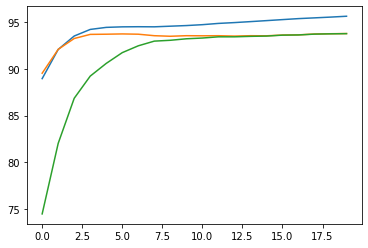

In [49]:
accuracies = np.array(accuracy_list)
plt.plot(accuracies[:,0], label='train')
plt.plot(accuracies[:,1], label='test')
plt.plot(accuracies[:,2], label='test_hard')

## Hard forward

In [50]:
yout = sdt.forward_hard(test_data)
outputs = tnn.Logits.logit_to_index(yout)
correct = (outputs == np.array(test_label_)).sum()

accuracy = correct / len(test_label_) * 100.
print('   TEST  ','accuracy = ', accuracy)
print(correct, '/', len(test_label_))  

   TEST   accuracy =  93.76
9376 / 10000


In [51]:
sdt_backup0 = copy.deepcopy(sdt)

## Cyclic hardening and softening

In [71]:
np.random.seed(27)
tree_depth = 3
sdt = InnerNode(input_size, output_size)
sdt.create_child(tree_depth)

In [64]:
learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 20

accuracy_list = []
for epoch in range(EPOCHS):
            
#     mag = np.power(10,epoch%5)
#     sdt.harden_decision(mag)
    
    num_batches = train_size // batch_size
    for index in range(num_batches):
        epoch_ = epoch+index/num_batches
        mag = np.power(10,epoch_%4)
        sdt.harden_decision(mag)
    
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()
        if index % 100 == 0:
            print('\nTRAIN',index, '-> ', loss)

    yout = sdt.forward(train_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(train_label_)).sum()

    accuracy = correct / len(train_label_) * 100.
    print('EPOCH = ',epoch,'accuracy = ', accuracy)
    print(correct, '/', len(train_label_))

    yout = sdt.forward(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy_ = correct / len(test_label_) * 100.
    print('   TEST  ','accuracy = ', accuracy_)
    print(correct, '/', len(test_label_))  
    
    yout = sdt.forward_hard(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy__ = correct / len(test_label_) * 100.
    print('   TEST (hard) ','accuracy = ', accuracy__)
    print(correct, '/', len(test_label_))  
    
    accuracy_list.append((accuracy, accuracy_, accuracy__))
    print('Weight Magnitude:', mag)


TRAIN 0 ->  6.455471059538213

TRAIN 100 ->  6.215225145722625

TRAIN 200 ->  6.134832466816281

TRAIN 300 ->  5.978044160721071

TRAIN 400 ->  5.989091035709297

TRAIN 500 ->  5.93175592468449

TRAIN 600 ->  5.894339417694617

TRAIN 700 ->  5.973768998544714

TRAIN 800 ->  5.871888894479709

TRAIN 900 ->  5.887766696783874
EPOCH =  0 accuracy =  87.725
52635 / 60000
   TEST   accuracy =  87.94999999999999
8795 / 10000
   TEST (hard)  accuracy =  81.63
8163 / 10000
Weight Magnitude: 9.975456155590589

TRAIN 0 ->  5.8381035936243535

TRAIN 100 ->  5.842262313633261

TRAIN 200 ->  5.835303508628991

TRAIN 300 ->  5.815306108173374

TRAIN 400 ->  5.828967327153787

TRAIN 500 ->  5.829266095659088

TRAIN 600 ->  5.814503746880153

TRAIN 700 ->  5.8874693798133775

TRAIN 800 ->  5.8471522218387735

TRAIN 900 ->  5.851605839963389
EPOCH =  1 accuracy =  89.215
53529 / 60000
   TEST   accuracy =  89.34
8934 / 10000
   TEST (hard)  accuracy =  88.75999999999999
8876 / 10000
Weight Magnitude: 


TRAIN 300 ->  5.733252130598887

TRAIN 400 ->  5.700903818919253

TRAIN 500 ->  5.746216498551355

TRAIN 600 ->  5.696540332855941

TRAIN 700 ->  5.725978861793677

TRAIN 800 ->  5.70083281627721

TRAIN 900 ->  5.738330501661848
EPOCH =  16 accuracy =  95.95666666666666
57574 / 60000
   TEST   accuracy =  95.0
9500 / 10000
   TEST (hard)  accuracy =  94.24
9424 / 10000
Weight Magnitude: 9.975456155590583

TRAIN 0 ->  5.690698614513994

TRAIN 100 ->  5.690895274739702

TRAIN 200 ->  5.71435174581668

TRAIN 300 ->  5.73262890514156

TRAIN 400 ->  5.706789627393549

TRAIN 500 ->  5.730083399166868

TRAIN 600 ->  5.697697156424281

TRAIN 700 ->  5.728181164069458

TRAIN 800 ->  5.702329755368989

TRAIN 900 ->  5.74721382173238
EPOCH =  17 accuracy =  95.57
57342 / 60000
   TEST   accuracy =  94.45
9445 / 10000
   TEST (hard)  accuracy =  94.39999999999999
9440 / 10000
Weight Magnitude: 99.75456155590584

TRAIN 0 ->  5.6978911396453995

TRAIN 100 ->  5.692401250326884

TRAIN 200 ->  5.7179

In [65]:
np.linalg.norm(sdt.fc.weights)

9975.456155590064

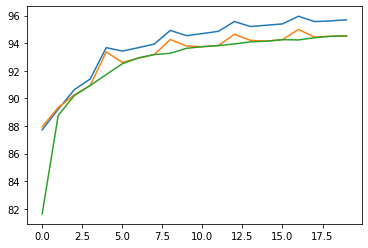

In [66]:
accuracies = np.array(accuracy_list)
plt.plot(accuracies[:,0], label='train')
plt.plot(accuracies[:,1], label='test')
plt.plot(accuracies[:,2], label='test_hard')

In [67]:
yout = sdt.forward_hard(test_data)
outputs = tnn.Logits.logit_to_index(yout)
correct = (outputs == np.array(test_label_)).sum()

accuracy = correct / len(test_label_) * 100.
print('   TEST  ','accuracy = ', accuracy)
print(correct, '/', len(test_label_))  

   TEST   accuracy =  94.53
9453 / 10000


## Recording data

In [ ]:
#####seed 7
### hardening
TRAIN 900 ->  5.73510994055256
EPOCH =  19 accuracy =  95.99166666666666
57595 / 60000
   TEST   accuracy =  94.01
9401 / 10000
   TEST (hard)  accuracy =  94.0
9400 / 10000
Weight Magnitude: 10000.0
    
### cyclic hardening
TRAIN 900 ->  5.729395766865222
EPOCH =  19 accuracy =  95.81333333333333
57488 / 60000
   TEST   accuracy =  94.71000000000001
9471 / 10000
   TEST (hard)  accuracy =  94.71000000000001
9471 / 10000
Weight Magnitude: 10000
    
#####seed 17
### hardening
TRAIN 900 ->  5.728265092794377
EPOCH =  19 accuracy =  95.71
57426 / 60000
   TEST   accuracy =  94.32000000000001
9432 / 10000
   TEST (hard)  accuracy =  94.32000000000001
9432 / 10000
Weight Magnitude: 10000.0

### cyclic hardening
TRAIN 900 ->  5.734597019344522
EPOCH =  19 accuracy =  95.69
57414 / 60000
   TEST   accuracy =  94.69999999999999
9470 / 10000
   TEST (hard)  accuracy =  94.69999999999999
9470 / 10000
Weight Magnitude: 10000
    
#####seed 27
### hardening
TRAIN 900 ->  5.756461421040446
EPOCH =  19 accuracy =  95.62
57372 / 60000
   TEST   accuracy =  93.77
9377 / 10000
   TEST (hard)  accuracy =  93.76
9376 / 10000
Weight Magnitude: 10000.0
    
### hardening-continuous
TRAIN 900 ->  5.760387118568312
EPOCH =  19 accuracy =  95.37
57222 / 60000
   TEST   accuracy =  93.62
9362 / 10000
   TEST (hard)  accuracy =  93.62
9362 / 10000
Weight Magnitude: 62940.87325910029
    
### cyclic hardening
TRAIN 900 ->  5.750807889449588
EPOCH =  19 accuracy =  95.48
57288 / 60000
   TEST   accuracy =  94.39
9439 / 10000
   TEST (hard)  accuracy =  94.39
9439 / 10000
Weight Magnitude: 10000

### cyclic hardening-continuous
TRAIN 900 ->  5.748428993157028
EPOCH =  19 accuracy =  95.69666666666666
57418 / 60000
   TEST   accuracy =  94.53
9453 / 10000
   TEST (hard)  accuracy =  94.53
9453 / 10000
Weight Magnitude: 9975.456155590584